<a href="https://colab.research.google.com/github/Leo-Ram/Monitoreo/blob/master/btchora.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [37]:
# Import necessary libraries
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D, MaxPooling1D
from matplotlib import pyplot as plt

# Download Bitcoin historical data at 1-minute intervals
df = yf.download('BTC-USD', start='2024-02-10', end='2025-03-10', interval='1h')



#btc_data.to_csv('his7dias.csv', index=False)

[*********************100%***********************]  1 of 1 completed


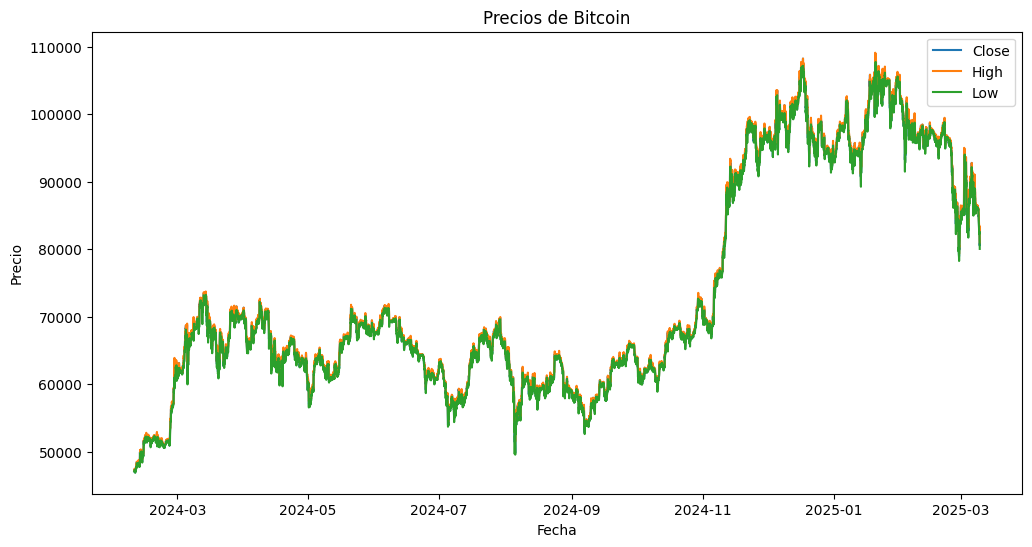

In [34]:
# Suponiendo que tu DataFrame se llama 'df' y las columnas que quieres graficar son 'Close', 'High', 'Low'
plt.figure(figsize=(12, 6))  # Ajusta el tamaño de la figura si lo necesitas

# Grafica cada columna con una etiqueta
plt.plot(df.index, df['Close'], label='Close')
plt.plot(df.index, df['High'], label='High')
plt.plot(df.index, df['Low'], label='Low')

# Agrega títulos y etiquetas
plt.title('Precios de Bitcoin')
plt.xlabel('Fecha')
plt.ylabel('Precio')

# Muestra la leyenda para identificar las líneas
plt.legend()

# Muestra la gráfica
plt.show()

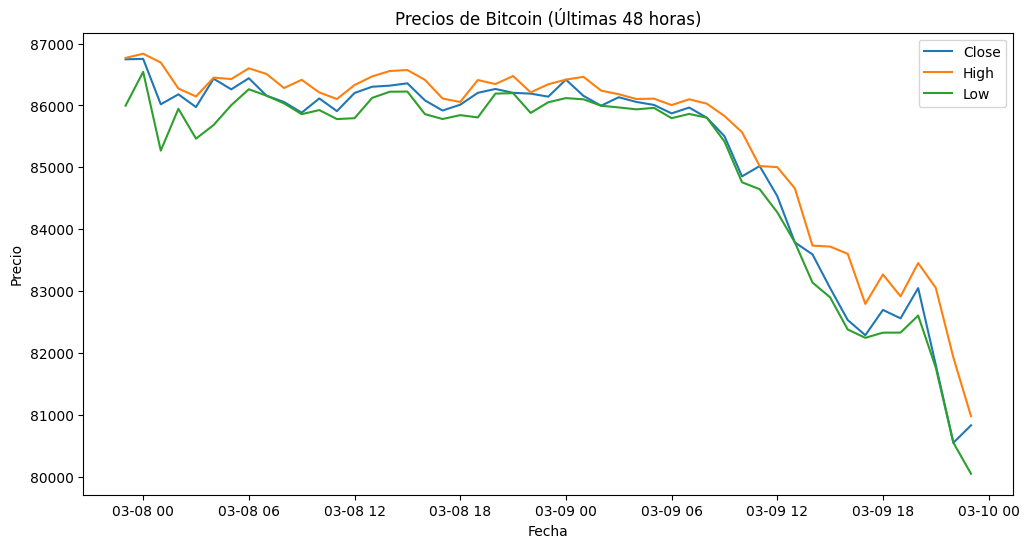

In [38]:

# Filtrar el DataFrame para las últimas 3 horas
last_3_hours = df[df.index >= df.index[-1] - pd.Timedelta(hours=48)] #se calcula la hora actual - 3 horas

# Graficar las últimas 3 horas
plt.figure(figsize=(12, 6))
plt.plot(last_3_hours.index, last_3_hours['Close'], label='Close')
plt.plot(last_3_hours.index, last_3_hours['High'], label='High')
plt.plot(last_3_hours.index, last_3_hours['Low'], label='Low')

plt.title('Precios de Bitcoin (Últimas 48 horas)')
plt.xlabel('Fecha')
plt.ylabel('Precio')
plt.legend()
plt.show()

In [23]:
# Cargar tus datos (ejemplo)
data = df[["Close", "High", "Low"]].values

# Normalizar los datos
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Crear secuencias de datos
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data)-seq_length-1):
        X.append(data[i:(i+seq_length), :])
        y.append(data[i+seq_length, 0])  # Predecir "Close"
    return np.array(X), np.array(y)

seq_length = 24  # Usar 24 datos previos para predecir
X, y = create_sequences(scaled_data, seq_length)

# Dividir en train/test
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [24]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(seq_length, 3)))
model.add(LSTM(50))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [25]:
model.fit(X_train, y_train,
          epochs=50,
          batch_size=24,
          validation_data=(X_test, y_test))

Epoch 1/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - loss: 0.0110 - val_loss: 5.0698e-04
Epoch 2/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - loss: 2.1145e-04 - val_loss: 5.7967e-04
Epoch 3/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - loss: 2.1706e-04 - val_loss: 4.4463e-04
Epoch 4/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - loss: 1.7758e-04 - val_loss: 3.6220e-04
Epoch 5/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - loss: 1.5344e-04 - val_loss: 2.8535e-04
Epoch 6/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - loss: 1.5764e-04 - val_loss: 4.2147e-04
Epoch 7/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - loss: 1.4529e-04 - val_loss: 2.3261e-04
Epoch 8/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - loss: 1.2931e-04 - val_loss: 2.0831e-04
Epoch 9/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - loss: 1.2556e-04 - val_loss: 2.3890e-04
Epoch 10/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 1.0659e-04 - val_loss: 1.8042e-04
Epoch 11/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/

In [31]:
def predict(model, last_sequence, scaler, steps=12):
    predictions = []
    current_sequence = last_sequence.copy()

    for _ in range(steps):
        # Predecir el próximo valor de "Close"
        next_pred = model.predict(current_sequence.reshape(1, seq_length, 3))
        predictions.append(next_pred[0,0])

        # Crear un nuevo paso temporal con valores dummy para High/Low
        new_step = np.array([[next_pred[0,0], 0, 0]])
        new_step = scaler.transform(new_step)  # Normalizar

        # Actualizar la secuencia
        current_sequence = np.roll(current_sequence, -1, axis=0)
        current_sequence[-1] = new_step

    # Invertir la normalización solo para la columna "Close"
    inverse_scaler = MinMaxScaler(feature_range=(0, 1))
    inverse_scaler.min_, inverse_scaler.scale_ = scaler.min_[0], scaler.scale_[0]

    return inverse_scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


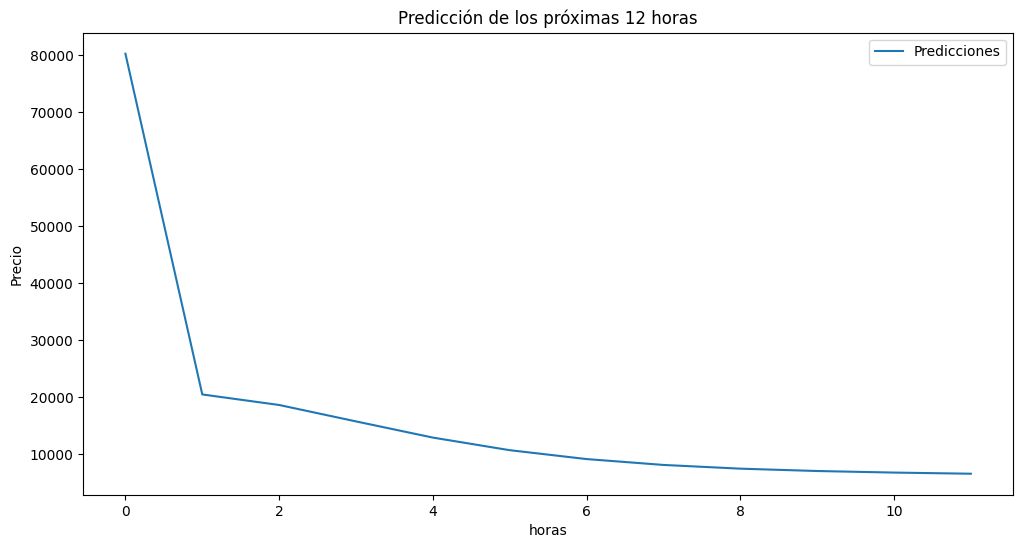

In [39]:
# Obtener la última secuencia del dataset
last_sequence = scaled_data[-seq_length:]

# Predecir
future_predictions = predict(model, last_sequence, scaler)

# Visualizar
plt.figure(figsize=(12,6))
plt.plot(future_predictions, label='Predicciones')
plt.title('Predicción de los próximas 12 horas')
plt.xlabel('horas')
plt.ylabel('Precio')
plt.legend()
plt.show()